<a href="https://colab.research.google.com/github/JoseFranUdea/Proyecto_Fundamentos_Deep_Learning/blob/main/modelo1_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Este cuaderno se puede ejecutar en kaggle, con los datos de la competencia plant pathology 2021

**En este cuaderno solo se tienen resultados para poder subir a la competencia**

In [2]:
from tensorflow.keras.utils import to_categorical
import numpy as np
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from skimage import exposure
import cv2 as cv
import os
import itertools
import seaborn as sns
import os
import multiprocessing as mproc
from keras.preprocessing import image
from tensorflow.keras.preprocessing import image
import os
from matplotlib.pyplot import figure

from tqdm import tqdm
%matplotlib inline

print("ejecutado")

ejecutado


In [3]:
import tensorflow as tf

gpucheck = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpucheck:
    print("Name:", gpu.name, "  Type:", gpu.device_type)
tf.test.is_gpu_available()

print("ejecutado")

ejecutado


In [4]:
train_dir = '/kaggle/input/plant-pathology-2021-fgvc8/train_images/'
test_dir =  '/kaggle/input/plant-pathology-2021-fgvc8/test_images/'
df = pd.read_csv('../input/plant-pathology-2021-fgvc8/train.csv')

print("direcciones cargadas")

direcciones cargadas


In [5]:
train_files = glob(train_dir + '/*.jpg')
test_files = glob(test_dir + '/*.jpg')
print('# files for train',len(train_files))
print('# files for train',len(test_files))

# files for train 18632
# files for train 3


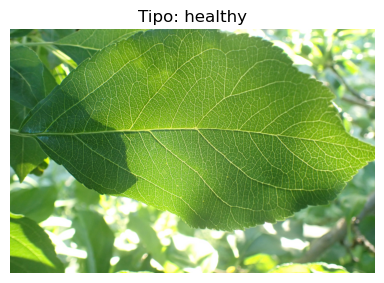

In [6]:
def visualize_batch(path,image_ids, labels):
    plt.figure(figsize=(16, 12))
    for ind, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, ind + 1)
        image = cv.imread(os.path.join(path, image_id))

        if image is not None:
         image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
         plt.imshow(image)
         plt.title(f"Tipo: {label}", fontsize=12)
         plt.axis("off")
         plt.show()
        else:
          print("Debido a que el dataset se redujo, no se pudo cargar la imagen, vuelva a ejecutar.")


ts = df.sample(1)  #Solo mostraremos una
image_ids = ts["image"].values
labels = ts["labels"].values

visualize_batch(train_dir,image_ids,labels)

scab                               4826
healthy                            4624
frog_eye_leaf_spot                 3181
rust                               1860
complex                            1602
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             120
rust complex                         97
powdery_mildew complex               87
Name: labels, dtype: int64


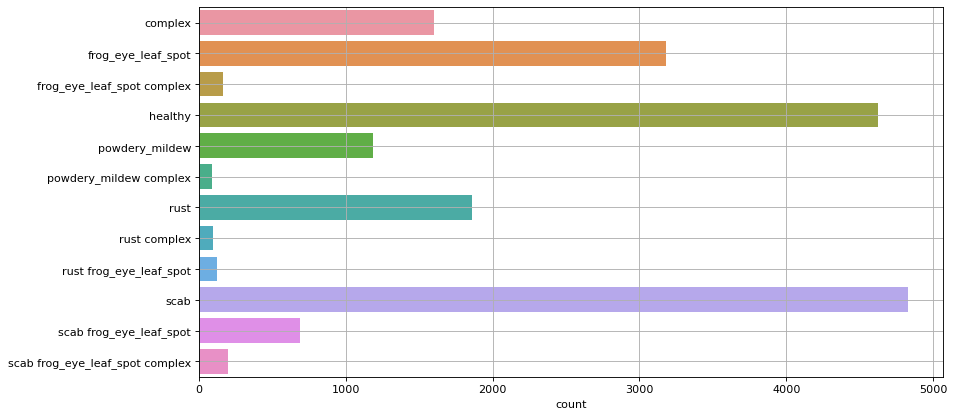

In [7]:

all_labels = list(itertools.chain([lbs for lbs in df['labels']]))
figure(figsize=(12, 6), dpi=80)

ax = sns.countplot(y=sorted(all_labels), orient='x')
ax.grid()

print(df.labels.value_counts())

In [8]:
# converting labels to binary attributes
#Se crea una copia de train
train = df.copy()
#Se crea una lista de etiquetas para la copia de train
train['labels'] = df['labels'].apply(lambda string: string.split(' '))

#Transforma las etiquetas para en un formato binario
s = list(train['labels'])
mlb = MultiLabelBinarizer()

#crea el data frame trainx aplicando las transformaciones de s, los nombres de las columnas se
# se obtienen con mlb.classes, los indices se mantienen de la misma manera que los índices de train

trainx = pd.DataFrame(mlb.fit_transform(s), columns=mlb.classes_, index=train.index)
#agrega la columna de imagenes del dataframe de train a trainx
trainx['image'] = train['image']


#Se verifica coom estan los datos

print(trainx.head(10))
print(trainx.columns)

   complex  frog_eye_leaf_spot  healthy  powdery_mildew  rust  scab  \
0        0                   0        1               0     0     0   
1        1                   1        0               0     0     1   
2        0                   0        0               0     0     1   
3        0                   0        0               0     0     1   
4        1                   0        0               0     0     0   
5        0                   0        1               0     0     0   
6        0                   0        0               0     1     0   
7        0                   0        1               0     0     0   
8        1                   0        0               0     0     0   
9        0                   0        1               0     0     0   

                  image  
0  800113bb65efe69e.jpg  
1  8002cb321f8bfcdf.jpg  
2  80070f7fb5e2ccaa.jpg  
3  80077517781fb94f.jpg  
4  800cbf0ff87721f8.jpg  
5  800edef467d27c15.jpg  
6  800f85dc5f407aef.jpg  
7  801d6dc

In [9]:
# training parameters
TARGET_SIZE = 128
BATCH_SIZE = 64
EPOCHS = 10
DATA_LIMIT = 10000
trainx = trainx[:DATA_LIMIT] 

In [10]:
from tensorflow.keras.preprocessing import image
import os

train_image = []
trainxN = []
Y = []

for i in tqdm(range(trainx.shape[0])):
    try:
        img_path = os.path.join(train_dir, trainx['image'][i])
        
        #Check if the image file exists
        if not os.path.isfile(img_path):
            print(f"Imagen no encontrada {img_path}. Saltando a la siguiente imagen.")
            continue
            
        trainxN.append(trainx.iloc[i])
        
        img = image.load_img(img_path, target_size=(TARGET_SIZE, TARGET_SIZE, 3))
        img = image.img_to_array(img)
        img = img / 255
        train_image.append(img)
        
        y = trainx.iloc[i].drop(['image'], axis=0)
        Y.append(y)

    except Exception as e:
        print(f"Error al procesar imagen {img_path}: {str(e)}")
        continue

X = np.array(train_image)  #Formato de imagen
Y = np.array(Y)
Y64 = Y.astype(np.int64)
trainxNdf = pd.DataFrame(trainxN)  #Formato de tabla

100%|██████████| 10000/10000 [15:48<00:00, 10.54it/s]


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, Y64, test_size=0.1)

In [13]:
#Modelo02

#Modelo objetivo
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(TARGET_SIZE,TARGET_SIZE,3)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 16)      1216      
                                                                 
 dropout (Dropout)           (None, 124, 124, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 32)      12832     
                                                                 
 dropout_1 (Dropout)         (None, 120, 120, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 116, 116, 64)      51264     
                                                                 
 dropout_2 (Dropout)         (None, 116, 116, 64)      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      1

In [14]:
model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test), batch_size=BATCH_SIZE)

Epoch 1/10
141/141 [==============================] - 2188s 16s/step - loss: 0.6397 - accuracy: 0.2284 - val_loss: 0.5014 - val_accuracy: 0.2850
Epoch 2/10
141/141 [==============================] - 2153s 15s/step - loss: 0.4712 - accuracy: 0.2479 - val_loss: 0.4291 - val_accuracy: 0.3100
Epoch 3/10
141/141 [==============================] - 2099s 15s/step - loss: 0.4517 - accuracy: 0.2862 - val_loss: 0.4277 - val_accuracy: 0.3190
Epoch 4/10
141/141 [==============================] - 2101s 15s/step - loss: 0.4424 - accuracy: 0.3018 - val_loss: 0.4096 - val_accuracy: 0.3530
Epoch 5/10
141/141 [==============================] - 2099s 15s/step - loss: 0.4351 - accuracy: 0.3190 - val_loss: 0.4246 - val_accuracy: 0.3060
Epoch 6/10
141/141 [==============================] - 2103s 15s/step - loss: 0.4288 - accuracy: 0.3412 - val_loss: 0.4083 - val_accuracy: 0.3920
Epoch 7/10
141/141 [==============================] - 2105s 15s/step - loss: 0.4264 - accuracy: 0.3410 - val_loss: 0.4088 - val_ac

In [15]:
# Setting the occuring as the class predicted by model.predict() will be valid
name = {0: 'complex',
        1: 'frog_eye_leaf_spot',
        2: 'healthy',
        3: 'powdery_mildew',
        4: 'rust',
        5: 'scab'}

threshold = {0: 0.3,
             1: 0.3,
             2: 0.4,
             3: 0.3,
             4: 0.3,
            5:0.3}

In [16]:
# The class labels are concatenated into a string and written to the final submission.csv dataframe
im_labels = []

for z in test_files:  #test files son los de prueba que nos proporcionó kaggle
    
    img = image.load_img(z,target_size=(TARGET_SIZE,TARGET_SIZE,3))
    img = image.img_to_array(img)
    img = img/255
    
    proba = list(model.predict(img.reshape(1,TARGET_SIZE,TARGET_SIZE,3))[0])
    filename = z.split('/')[-1]
    p = []
    for i in range(len(proba)):
        if proba[i] > threshold[i]:
            p.append(name[i])
            
    im_labels.append({'image': filename, 'labels': ' '.join(p)})
    
df = pd.DataFrame(im_labels)
df.to_csv('submission.csv', index=False)
df.head()

1/1 [==============================] - 0s 120ms/step


,image,labels
0,ad8770db05586b59.jpg,complex
1,c7b03e718489f3ca.jpg,scab
2,85f8cb619c66b863.jpg,
